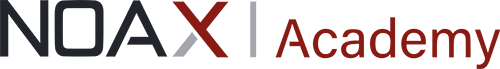

# Deep Learning: ¡cuánto más, mejor!
#### **Alejandro Baldominos** 

Este cuaderno complementa al artículo del blog de NOAX Academy. [¡Léelo ahora!](https://blog.noaxacademy.com/deep-learning-cuanto-mas-mejor).

En el pasado, hemos visto cómo podemos emplear técnicas de aprendizaje profundo (_Deep Learning_) para conseguir un modelo que sea capaz de diferenciar entre fotos de perros y fotos de gatos.

En concreto, lo que hicimos fue entrenar una red de neuronas convolucional. Este tipo de redes son ideales para realizar tareas de visión por computador, en las cuáles se dispone de un conjunto de imágenes sobre las que se quiere hacer algo (por ejemplo, clasificar el objeto —o animal— que aparece en ellas).

En esa ocasión, fuimos capaces de acertar un 73,5% de las veces el animal que aparecía en la fotografía, ya fuera un perro o un gato. No está mal, pero tampoco parece un resultado escandalosamente bueno. Por ello, puede surgirnos una pregunta: __¿podemos mejorar aún más este resultado?__

## El aumento de los datos

Cuando trabajamos con técnicas de Deep Learning, suele ocurrir que los resultados mejoran cuantos más datos tenemos. En nuestro modelo que distinguía perros de gatos, hemos empleado 2000 imágenes para entrenar el modelo (además, validamos el modelo con otras 1000 imágenes completamente distintas de las anteriores).

2000 imágenes pueden parecer muchas, pero en realidad no lo son. Cuando trabajamos con Deep Learning, 2000 imágenes suelen ser bastante pocas. Hay que tener en cuenta que nosotros queremos que nuestro modelo vea fotos de perros y gatos de todos los modos posibles: diferentes razas, con diferentes perspectivas, etc. Eso es difícil de conseguir si solo tenemos 2000 imágenes.

Y ahora llega la gran pregunta: ¿de dónde demonios sacamos más imágenes? Bueno, siempre podemos tomar nuestra cámara de fotos, salir a la calle, e ir haciendo fotos a perros y gatos. Luego tendremos que etiquetar estas fotos, es decir, indicarle al modelo cuáles son de perros y cuáles son de gatos.

Vale, estoy de acuerdo, no parece la mejor opción. Primero, quizás no nos apetezca salir a la calle. Tal vez no tengamos una cámara de fotos decente. Puede que algún dueño se moleste si vamos haciendo fotos a sus mascotas. A decir verdad, parecen todo inconveniente…

¡Pero no todo está perdido! Es cierto que conseguir imágenes de nuevos perros y gatos parece complicado (salvo que las descarguemos de Internet, claro). Sin embargo, si ya tenemos imágenes de perros y gatos, no parece muy complicado crear nuevas imágenes con nuevas perspectivas, ¿no?

¿Que cómo podemos hacerlo? ¿Qué tal así?

![Aumento de los datos empleando cuatro variaciones distintas: zoom, rotación, traslación y volteo horizontal](https://blog.noaxacademy.com/wp-content/uploads/2021/12/noax_academy_blog_baldo_deeplearning_augment.svg)
**Figura 1 |** Aumento de los datos empleando cuatro variaciones distintas: zoom, rotación, traslación y volteo horizontal.

Vale, estoy de acuerdo: ¡todos son el mismo gato! Sin embargo, aunque parezca que no estamos aportando nada nuevo, en realidad sí lo estamos haciendo: le estamos proporcionando a nuestro modelo nuevas perspectivas. Cuando el modelo se encuentre con una foto de un gato, puede que la foto esté algo torcida, puede que el gato salga algo más grande o más pequeño, mirando hacia un lado o hacia el otro… ¡eso es justo lo que estamos controlando aquí!

Ahora bien, ¿cómo creamos todas estas nuevas imágenes? ¿Tendremos que pagar la licencia de Photoshop e ir una por una realizando todas estas transformaciones?

Pues no, eso no será necesario. Lo cierto es que TensorFlow y Keras tienen mecanismos para hacer esto automáticamente. ¿No es maravilloso?

Pues bien, sabiendo todo esto, pongámonos manos a la obra.

## Carga de los datos

El primer paso será cargar los datos. Este proceso lo podemos llevar a cabo como ya hicimos en la entrega anterior. Primero, descargaremos y descomprimiremos el conjunto de imágenes:

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O cats_and_dogs_filtered.zip
!unzip -qq cats_and_dogs_filtered.zip

A continuación, importaremos las dependencias necesarias para trabajar, y acto seguido podremos cargar las imágenes del conjunto de datos, tanto las que usaremos para entrenar, como las que emplearemos para validar el modelo:

In [ ]:
from IPython import display         # Gestión de la salida en el cuaderno.
import matplotlib.pyplot as plt     # Graficado de las imágenes por pantalla.
import numpy as np                  # Creación de tensores. 
from sklearn import metrics         # Cálculo de métricas
import tensorflow.keras as K        # Construcción de modelos CNN.
import time                         # Espera entre el graficado de imágenes.

%matplotlib inline

# Conjunto de entrenamiento.
train = K.preprocessing.image_dataset_from_directory('cats_and_dogs_filtered/train/', 
                                                     image_size=(150, 150), 
                                                     label_mode='binary')
# Conjunto de validación.                                                     
valid = K.preprocessing.image_dataset_from_directory('cats_and_dogs_filtered/validation/', 
                                                     image_size=(150, 150), 
                                                     label_mode='binary')
classes = train.class_names

## Diseño del modelo

Para poder entender el efecto que tiene el aumento de datos en el rendimiento de nuestro modelo, vamos a emplear exactamente la misma arquitectura que ya empleamos en nuestro clasificador de perros y gatos. Recordemos que nuestro modelo se componía de las siguientes capas:

+ **Tres capas convolucionales** con 16, 32 y 64 filtros respectivamente, de tamaño 3x3 y función de activación **ReLU**.
+ Cada capa convolucional estará seguida de una capa de **max pooling** de tamaño 2x2, que permite reducir la dimensionalidad mediante una agregación local.
+ Tras estas capas, se _aplanará_ la salida y se introducirá a **una capa densa** con 512 neuronas y función de activación **ReLU**, sobre cuya salida se realizará un **dropout** del 50%.
+ Finalmente, la capa de salida tendrá una única neurona con función de activación sigmoidal.

In [ ]:
"""
Creamos el modelo secuencial
"""
model = K.Sequential()

"""
Añadimos la capa de entrada
Recordemos que las imágenes son RGB con tamaño 150x150
"""
model.add(K.layers.InputLayer(input_shape=(150, 150, 3)))

"""
Vamos a reescalar los valores de los píxeles en el rango 0-1
"""
model.add(K.layers.experimental.preprocessing.Rescaling(1./255))

"""
Añadimos la primera capa convolucional seguida de max-pooling
Debe tener 16 filtros de tamaño 3x3 y activación ReLU
"""
model.add(K.layers.Conv2D(16, 3, activation='relu'))
model.add(K.layers.MaxPooling2D(2))

"""
Añadimos la segunda capa convolucional seguida de max-pooling
Debe tener 32 filtros de tamaño 3x3 y activación ReLU
"""
model.add(K.layers.Conv2D(32, 3, activation='relu'))
model.add(K.layers.MaxPooling2D(2))

"""
Añadimos la tercera capa convolucional seguida de max-pooling
Debe tener 64 filtros de tamaño 3x3 y activación ReLU
"""
model.add(K.layers.Conv2D(64, 3, activation='relu'))
model.add(K.layers.MaxPooling2D(2))

"""
Añadimos la capa que «aplana» la salida de la red para introducirla
a una secuencia de capas densas
"""
model.add(K.layers.Flatten())

"""
Añadimos la capa densa con 512 neuronas y activación ReLU
seguida de una capa de «dropout» del 50%
"""
model.add(K.layers.Dense(512, activation='relu'))
model.add(K.layers.Dropout(0.5))

"""
Añadimos la capa de salida, con una neurona y activación sigmoidal
"""
model.add(K.layers.Dense(1, activation='sigmoid'))

"""
Imprimimos el resumen del modelo
"""
model.summary()

## Aumentado de datos

En cualquier otra ocasión, ya estaríamos en condiciones de comenzar con el entrenamiento del modelo. Sin embargo, ¡ahora tenemos un paso previo que hacer!

Para realizar el aumentado de datos, vamos a emplear lo que en Keras se denomina «un generador». Este generador recibe como entrada un conjunto de datos, que será nuestro conjunto de entrenamiento —recordemos que tenía 2000 imágenes. Lo que hará el generador es ir creando nuevas imágenes, a partir de las originales. Cada vez que el entrenamiento necesite más imágenes, el generador se las dará… ¡y serán todas distintas! Así, aunque solo tengamos 2000 imágenes, realmente podemos generar un número infinito de ellas, por lo que nuestro conjunto de entrenamiento pasa a ser mucho más versátil.

¿Cómo se crea este generador? Lo primero que tenemos que hacer es indicarle al generador qué posibles cambios podemos hacer en la imagen. Por ejemplo, podemos emplear el siguiente código:

In [ ]:
"""
Creamos el generador de datos con cinco posibles modificaciones.
"""
aug_gen = K.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True, 
    rotation_range=30, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    zoom_range=0.2
)

Así, le indicamos al generador que puede realizar las siguientes transformaciones sobre la imagen:

+ Volteo horizontal.
+ Rotación de hasta 30º.
+ Traslación horizontal de hasta el 20%.
+ Traslación vertical de hasta el 20%.
+ Zoom de entre el 80% y el 120%.

Consultando [la documentación del ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) podemos entender mejor los tipos de transformaciones que son posibles. En la práctica, se pueden realizar numerosas transformaciones, incluyendo cambiar el brillo de la imagen, voltearla, rotarla, etc. Con los parámetros, podemos controlar el efecto de estas transformaciones. Por ejemplo, puede que nos interese rotar un poco la imagen, pero tampoco en exceso (o corremos el riesgo de tener un gato boca abajo).

El generador aplicará estas transformaciones de forma aleatoria, dentro de los márgenes establecidos, permitiendo así generar imágenes nuevas y completamente distintas unas de otras.

El siguiente paso será conectar este generador de imágenes con nuestro conjunto de entrenamiento:

In [ ]:
"""
Obtenemos las imágenes y etiquetas del conjunto de datos
"""
X_train, y_train = np.array([]).reshape(-1, 150, 150, 3), np.array([]).reshape(-1, 1)
for X, y in train:
    X_test = np.concatenate([X_train, X])
    y_test = np.concatenate([y_train, y])
train_aug = aug_gen.flow(X_train, y_train)

## Entrenamiento del modelo

Ahora sí, ya estamos en condiciones de poner a entrenar nuestro modelo. El proceso es casi idéntico al que ya hicimos en su momento, con una sutil diferencia. ¿Puedes encontrarla?

In [ ]:
"""
Compilamos el modelo construido
"""
model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
 
"""
Vamos a crear un «callback» que guarde el mejor modelo obtenido durante el entrenamiento
"""
checkpoint = K.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, mode='auto')  
 
"""
Entrenamos el modelo, empleando el generador de imágenes creado anteriormente
"""
model.fit(train_aug, epochs=20, validation_data=valid, verbose=1, callbacks=[checkpoint])

Exacto! La única diferencia es que cuando hacemos el entrenamiento como tal, antes introducíamos la variable `train` (que tenía nuestro conjunto de entrenamiento), mientras que ahora introducimos el generador que aumenta nuestro conjunto de datos, llamado `train_aug`.

## Evaluación del modelo

Por último, podemos obtener la tasa de aciertos del modelo sobre el conjunto de validación y mostrar la matriz de confusión:

In [ ]:
"""
Cargamos el mejor modelo encontrado durante el entrenamiento
"""
model = K.models.load_model('model.h5')

"""
Calculamos la tasa de acierto del modelo.
"""
acc = model.evaluate(valid)

"""
Imprimimos la tasa de aciertos
"""
print("Tasa de aciertos sobre validación: {:.2f}%".format(acc[1] * 100))

"""
A continuación, vamos a visualizar la matriz de confusión.
Esta matriz nos indica cuántos errores hay de cada tipo.
"""
X_test, y_test = np.array([]).reshape(-1, 150, 150, 3), np.array([]).reshape(-1, 1)
for X, y in valid:
    X_test = np.concatenate([X_test, X])
    y_test = np.concatenate([y_test, y])
y_prob = model.predict(X_test)
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_test, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cm.plot(values_format='', cmap='Blues')

¡Voilá! En poco tiempo hemos conseguido un modelo capaz de distinguir razonablemente bien las fotos de perros y gatos. Ahora bien, ¿podemos mejorar este modelo aún más? ¡Definitivamente sí! Pero eso es algo que dejaremos para otra ocasión...

#### Aprende más:
+ Más información sobre el problema de clasificación y algunos algoritmos (en inglés): https://towardsdatascience.com/machine-learning-classifiers-a5cc4e1b0623
+ Más información básica sobre redes de neuronas convolucionales (en inglés): https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
+ Más información, con ejemplos de código, sobre redes de neuronas convolucionales (en inglés): https://towardsdatascience.com/convolutional-neural-networks-e5a6745b2810

<h2>Acerca del autor</h2>

<img src="https://blog.noaxacademy.com/wp-content/uploads/2021/11/Alejandro_Baldominos-1024x576.jpeg" width="30%" alt="Alejandro Baldominos"
 style="float:left; margin-right: 1em;">
<div style="width:30%">
<h2>Alejandro Baldominos</h2>
<p>Doctor en Ciencia y Tecnología Informática por la Universidad Carlos III de Madrid. Docente, investigador, y colaborador con varias empresas tecnológicas. Me apasiona la ciencia de datos, el machine learning y la inteligencia artificial. También disfruto enseñando programación «bien», es decir, explicando cómo tomar las mejores decisiones para que nuestros programas sean lo mejor posible.</p>
</div>

 © 2021 NOAX Academy. Todos los derechos reservados. 